# Clone a Group 

This sample notebook can be used for cloning one or more groups, either on the same portal or from one portal to another.

**Note:** If you want to clone all portal users, groups and content refer to the sample 
[Clone Portal users, groups and content](clone_portal_users_groups_and_content.ipynb)

In this sample, we will clone the [Vector Basemaps](http://www.arcgis.com/home/group.html?id=30de8da907d240a0bccd5ad3ff25ef4a) group from ArcGIS Online to an ArcGIS Enterprise.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clone-a-Group" data-toc-modified-id="Clone-a-Group-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clone a Group</a></span><ul class="toc-item"><li><span><a href="#Define-the-source-and-target-portals" data-toc-modified-id="Define-the-source-and-target-portals-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define the source and target portals</a></span></li><li><span><a href="#Search-for-the-group-and-its-contents-in-the-source-portal" data-toc-modified-id="Search-for-the-group-and-its-contents-in-the-source-portal-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Search for the group and its contents in the source portal</a></span></li><li><span><a href="#Clone-the-group-in-the-target-portal-if-it-does-not-already-exist." data-toc-modified-id="Clone-the-group-in-the-target-portal-if-it-does-not-already-exist.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Clone the group in the target portal if it does not already exist.</a></span></li><li><span><a href="#Clone-the-contents-of-the-group-to-the-target-portal" data-toc-modified-id="Clone-the-contents-of-the-group-to-the-target-portal-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Clone the contents of the group to the target portal</a></span></li></ul></li></ul></div>

In [4]:
from arcgis.gis import GIS
from IPython.display import display
from arcgis.gis import ItemProperties

## Define the source and target portals

To start with, define the source and target portals.

In [7]:
# an anonymous connection to ArcGIS Online is sufficient, 
# since we are cloning a public group
source = GIS()

target = GIS(profile="your_organization_profile")

## Search for the group and its contents in the source portal
In the source portal, search for the group to be cloned. In our case the title of the group is 'Vector Basemaps'.

In [3]:
source_groups = source.groups.search("title:Vector Basemaps AND owner:esri", outside_org = True)
source_groups

[<Group title:"OpenStreetMap Vector Basemap" owner:esri>,
 <Group title:"United States Vector Tile Layers" owner:esri>,
 <Group title:"Vector Basemaps" owner:esri>,
 <Group title:"Vector Basemaps (for Export)" owner:esri>]

In [4]:
source_group = source_groups[2]
source_group

<Group title:"Vector Basemaps" owner:esri>

List the items that are a part of the group 'Vector Basemaps'.

In [5]:
source_items = source_group.content()
source_items

[<Item title:"Colored Pencil Map" type:Web Map owner:esri>]

## Clone the group in the target portal if it does not already exist. 

We create a new group in the target portal with all the properties of the group in the source portal. 

<Group title:"Vector Basemaps" owner:esri>
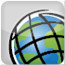

In [10]:
import tempfile
if not target.groups.search('Vector Basemaps'):
    try:
        with tempfile.TemporaryDirectory() as temp_dir:
            thumbnail_file = source_group.download_thumbnail(temp_dir)
            
            #create a group in the target portal with all the properties of the group in the source
            target_group = target.groups.create(title = source_group.title,
                                                 tags = source_group.tags,
                                                 description = source_group.description,
                                                 snippet = source_group.snippet,
                                                 access = source_group.access, 
                                                 thumbnail= thumbnail_file,
                                                 is_invitation_only = True,
                                                 sort_field = 'avgRating',
                                                 sort_order ='asc',
                                                 is_view_only=True)
            #display the group
            display(target_group)
            
    except Exception as e:
        print('Group {} could not be created'.format(source_group.title))
        print(e)
else:
    print('Group {} already exists in the portal'.format(source_group.title))
    target_group = target.groups.search('Vector Basemaps')[0]


## Clone the contents of the group to the target portal
It is possible that some items to be cloned may already be present on the target portal. In such a situation, we simply share those items with the target group. Thus, in the section below, we renew our list of items to be cloned by removing from it, any item that was existing on the target portal beforehand.

In [11]:
#making a list for the items to be cloned in the target portal
items_to_be_cloned = list(source_items)

#checking for the presence of the item in the target portal 
for item in source_items:
    searched_items = target.content.search(query='title:'+item.title, item_type = item.type)   
    
    for s_item in searched_items:
        
        if s_item.title == item.title:
            
            #if an item is not a part of the group in the target portal then share it 
            if s_item not in target_group.content():
                s_item.sharing.groups.add(
                    group=target_group
                )
            
            #remove the already existing item from the list of items to be cloned
            items_to_be_cloned.remove(item)                
            
            #display the item
            display(s_item)      
                     
            break


**Note:** The [GroupManager.clone()](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.GroupManager.clone) doesn't clone the group’s items, it only recreates groups from site A to site B. 

Now after having removed the existing items from the list of items to be cloned, we can easily copy the remaining content of the source group to the newly created group in the target portal.  

In [21]:
#cloning all items that were not present on the portal before
for item in items_to_be_cloned:    
    try:
        thumbnail_file = item.download_thumbnail()
        target_item_properties = ItemProperties(title=item.title,
                              tags=item.tags,
                              text=item.get_data(try_json=True),
                              item_type=item.type,
                              snippet=item.snippet,
                              description=item.description,
                              thumbnail=thumbnail_file)        
        #create an item
        root_folder = target.content.folders.get()
        job = root_folder.add(item_properties=target_item_properties, item_id=item.id)
        target_item = job.result()
        #share that item with the group on the target portal
        target_item.sharing.groups.add(
            group=target_group
        )
        
        #display the item
        display(target_item)
            
    except Exception as e:
        print('Item {} could not be created in the target portal'.format(item.title))
        print(e)

<Item title:"Colored Pencil Map" type:Web Map owner:esri>

Please see [GroupMigrationManager](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#groupmigrationmanager) for offline exporting of group items